<a href="https://www.kaggle.com/code/aaalexlit/yolo-followed-by-sam?scriptVersionId=160376463" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Install ultralytics library and copy previously finetuned yolov8 model

In [1]:
%%capture
!pip install --no-index -f /kaggle/input/download-ultralytics /kaggle/input/download-ultralytics/ultralytics-8.1.5-py3-none-any.whl

!mkdir trained_model
!cp /kaggle/input/yolo-10-epochs-size-1928-all-except-kidney_3_dense/pytorch/run_tm53kdwd_model/1/best.pt /kaggle/working/trained_model

## Imports

In [2]:
from ultralytics import YOLO
from ultralytics.models.sam import Predictor as SAMPredictor

import numpy as np
import pandas as pd

from ultralytics.engine.results import Results

## Utility functions for prediction conversions

In [3]:
def add_masks(masks):
    result = 255*(np.sum(masks, axis=0))
    result = result.clip(0, 255).astype("uint8")
    return result

In [4]:
def rle_encode(mask):
    pixel = mask.flatten()
    pixel = np.concatenate([[0], pixel, [0]])
    run = np.where(pixel[1:] != pixel[:-1])[0] + 1
    run[1::2] -= run[::2]
    rle = ' '.join(str(r) for r in run)
    if rle == '':
        rle = '1 0'
    return rle

In [5]:
def extract_id_from_result(result: Results):
    dataset_name = result.path.split('/')[-3]
    file_name = result.path.split('/')[-1].split('.')[0]
    return f'{dataset_name}_{file_name}'

In [6]:
def get_rle_from_result(result: Results):
    if not result.masks:
        return '1 0'
    else:
        masks_array = result.masks.data.cpu().numpy()
        combined_mask = add_masks(masks_array)
        return rle_encode(combined_mask)

# Inference
## Init previously fine-tuned yolov8 and off-the-shelf SAM model

In [7]:
yolo_confidence_threshold = 0.1
sam_confidence_threshold = 0.8

In [8]:
from glob import glob
is_submission = len(glob("/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/*.tif")) > 3

model = YOLO('/kaggle/working/trained_model/best.pt')

device = [0, 1] if is_submission else None
overrides = dict(conf=sam_confidence_threshold, 
                 task='segment', 
                 mode='predict', 
                 model='/kaggle/input/download-ultralytics/sam_b.pt',
                 device=device,
                )
predictor = SAMPredictor(overrides=overrides)

# Make predictions with yolov8
We will pass the bounding boxes predicted with yolov8 as prompts for SAM.

In [9]:
if is_submission:
    source = '/kaggle/input/blood-vessel-segmentation/test/**/*.tif'
    results = model.predict(source, 
                            # otherwise we get OOM
                            stream=True, 
                            # only to use T4 * 2
                            device=[0,1], 
                            # confidence threshold
                            conf=yolo_confidence_threshold)

In [10]:
if is_submission:
    submission_list = []
    for yolo_result in results:
        img_path = yolo_result.path
        if not yolo_result.masks:
            rle = '0 1'
        else:
            predictor.set_image(yolo_result.path)
            sam_results = predictor(bboxes=yolo_result.boxes.xyxy, labels=[1])
            rle = get_rle_from_result(sam_result[0])
            predictor.reset_image()
        img_id = extract_id_from_result(result)
        submission_list.append({
            'id': img_id,
            'rle': rle
        })

    df = pd.DataFrame(submission_list, columns=['id', 'rle'])

    df.to_csv('submission.csv', index=False)    

    

# Visualize on an individual image 

In [11]:
model = YOLO('/kaggle/working/trained_model/best.pt')

overrides = dict(conf=sam_confidence_threshold, 
                 task='segment', 
                 mode='predict', 
                 model='/kaggle/input/download-ultralytics/sam_b.pt',
                 device=device,
                 retina_masks=True
                )
predictor = SAMPredictor(overrides=overrides)

In [12]:
source = '/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images/1005.tif'
# source = '/kaggle/input/blood-vessel-segmentation/test/**/*.tif'
results = model.predict(source,  
                        # confidence threshold
                        conf=yolo_confidence_threshold)


image 1/1 /kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images/1005.tif: 1952x1376 82 Vessels, 1250.6ms
Speed: 49.6ms preprocess, 1250.6ms inference, 1487.3ms postprocess per image at shape (1, 3, 1952, 1376)


In [13]:
yolo_res = results[0]
predictor.set_image(yolo_res.path)
sam_results = predictor(bboxes=yolo_res.boxes.xyxy, labels=[1])


Ultralytics YOLOv8.1.5 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (Intel Xeon 2.20GHz)

image 1/1 /kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images/1005.tif: 1024x1024 12277.7ms
Speed: 0.0ms preprocess, 12277.7ms inference, 605.5ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs/segment/predict


## Plot results

### Masks from SAM with yolo bounding boxes as prompt

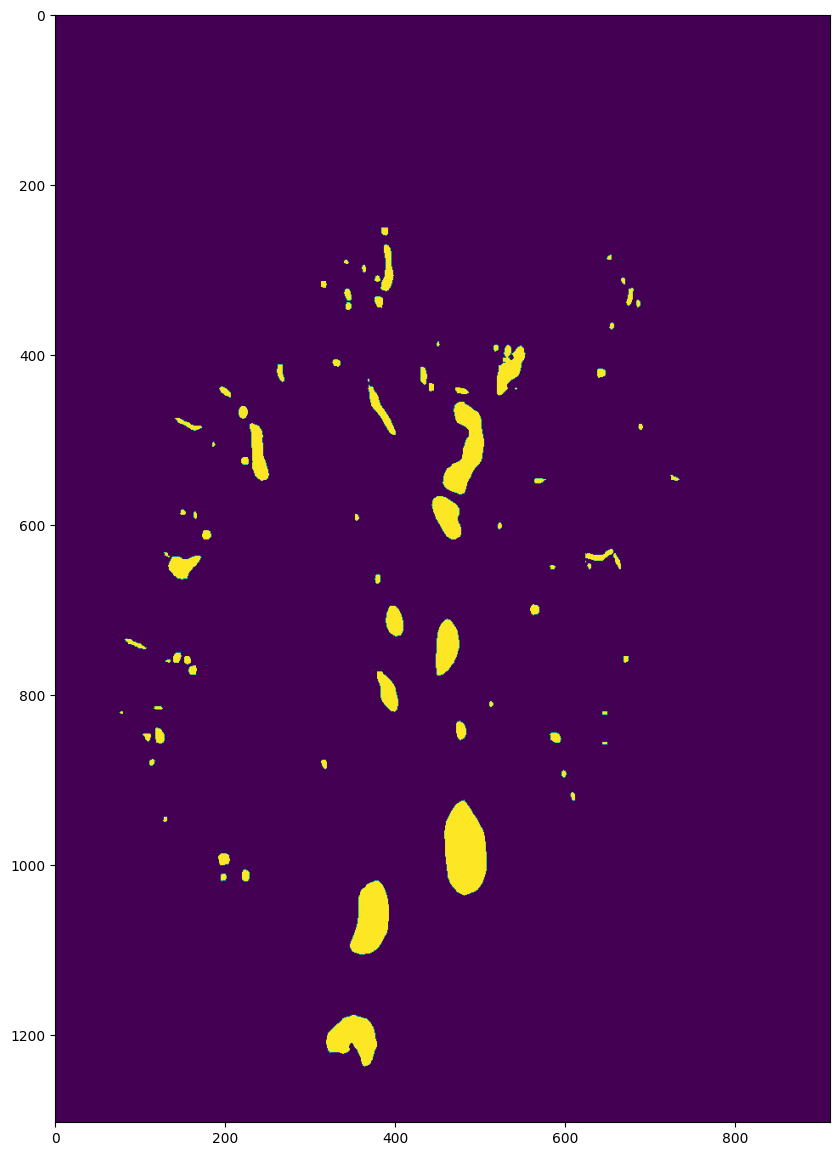

In [14]:
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(10, 15))
sam_masks = add_masks(sam_results[0].masks.data.cpu().numpy())
plt.imshow(sam_masks);

In [15]:
# plt.figure(figsize=(10, 15))
# plt.imshow(sam_results[0].plot())

### Masks from Yolo  

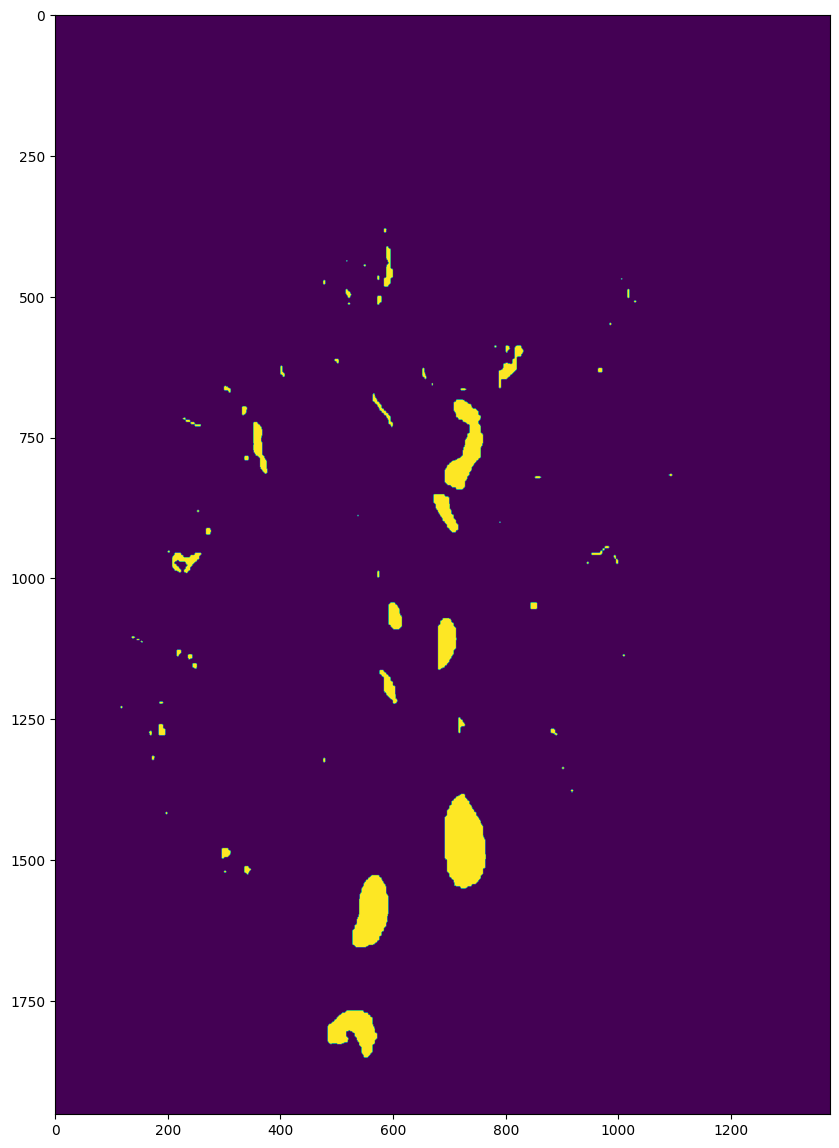

In [16]:
plt.figure(figsize=(10, 15))
yolo_masks = add_masks(yolo_res.masks.data.cpu().numpy())
plt.imshow(yolo_masks);

### Ground truth

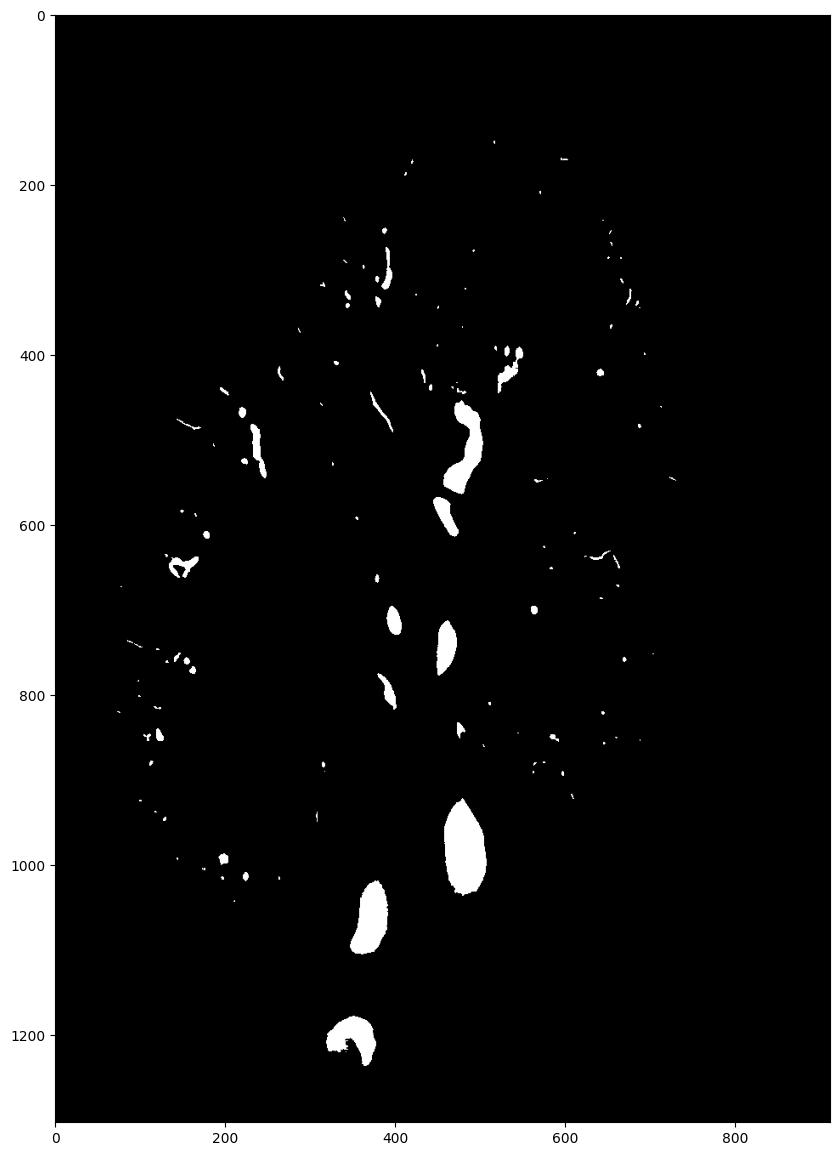

In [17]:
plt.figure(figsize=(10, 15))
groundtruth_mask = cv2.imread(yolo_res.path.replace('images', 'labels'))
plt.imshow(groundtruth_mask)

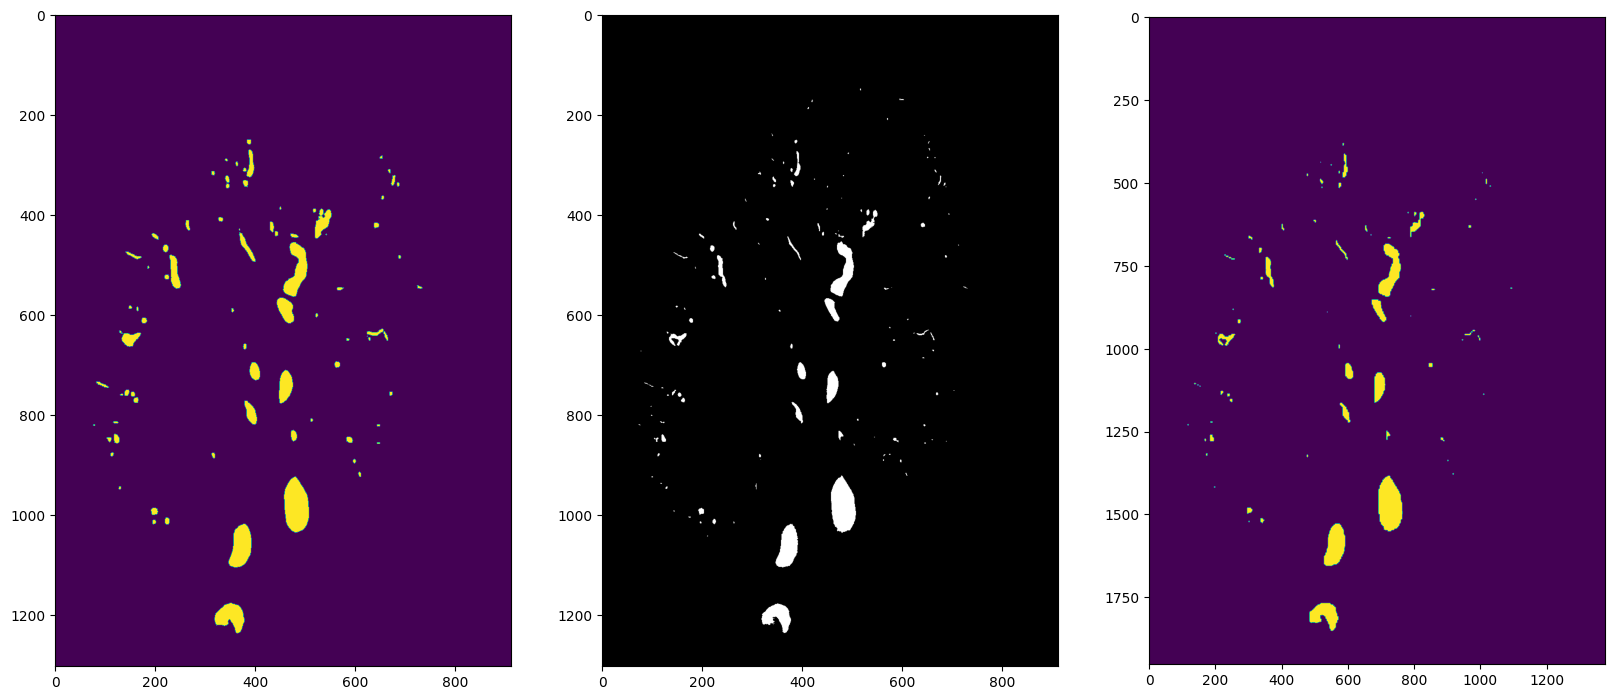

In [18]:
plt.figure(figsize=(20, 10))
all_masks = [sam_masks, groundtruth_mask, yolo_masks]
for n in range(3):
    ax = plt.subplot(1, 3, n + 1)
    ax.imshow(all_masks[n])


In [19]:
sam_masks.shape, groundtruth_mask.shape, yolo_masks.shape

((1303, 912), (1303, 912, 3), (1952, 1376))

In [20]:
cv2.imread(yolo_res.path.replace('images', 'labels')).shape, cv2.imread(yolo_res.path).shape

((1303, 912, 3), (1303, 912, 3))